# 链接仪器

In [1071]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab import wavepoint
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new, measureroutine_new
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
opt = imp.reload(opt)
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
mn = imp.reload(measureroutine_new)
wf = imp.reload(wavepoint)

In [1057]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
# ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
psg104 = await connect('PSG104')
psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

In [96]:
await psg103.setValue('Output','OFF')

# qubit工作点

In [45]:
freqall = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.607,6.63])*1e9
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}
atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex','alpha',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=-0.019,f_ex=2*6.3e9+2e6,power_ex=-2.73) #power=-2.1

## 保存工作点

In [180]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0517\QubitState\qubitstate_20200517222308.npz


## 提取工作点

In [6]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0515\QubitState\qubitstate_20200515090251.npz


## 保存提取全局变量

In [433]:
cw.saveStatus(fname='D:/status.obj')

In [5]:
cw.loadStatus(fname='D:/status.obj')

# 指定仪器

In [1058]:
psg_lo = psg104
psg_ex1 = psg105
psg_trans = psg230
psg_ex2 = psg106
psg_ex3 = psg103
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_ex2':psg_ex2,'psg_ex3':psg_ex3,'psg_pump':psg_pump,'psg_trans':psg_trans}
ats = ats18
awg_trig = awg100
dc = {'q2':dc01,'q6':dc02,'jpa':dc03,'q1':dc05,'q3':dc06,\
      'q8':dc07,'q7':dc08,'q10':dc10,'q4':dc11,'q5':dc15,'q9':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133}

## 测量类

In [13]:
measure = mr.common(f_cavity,ats,dc,psg,awg_list,jpa,[q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

In [972]:
await mr.awgSync(measure)

# 信号检查

In [1059]:
# delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
#        9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
delta = np.array([50e6])
await cw.modulation_read(measure,delta,tdelay=1300)
# await mr.ats_setup(ats,delta,l=180+128)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [34]:
f_list = await ats.setValue('repeats',201)

In [213]:
f_list = await ats.getValue('repeats')
f_list

512

## 复平面信号

<IPython.core.display.Javascript object>


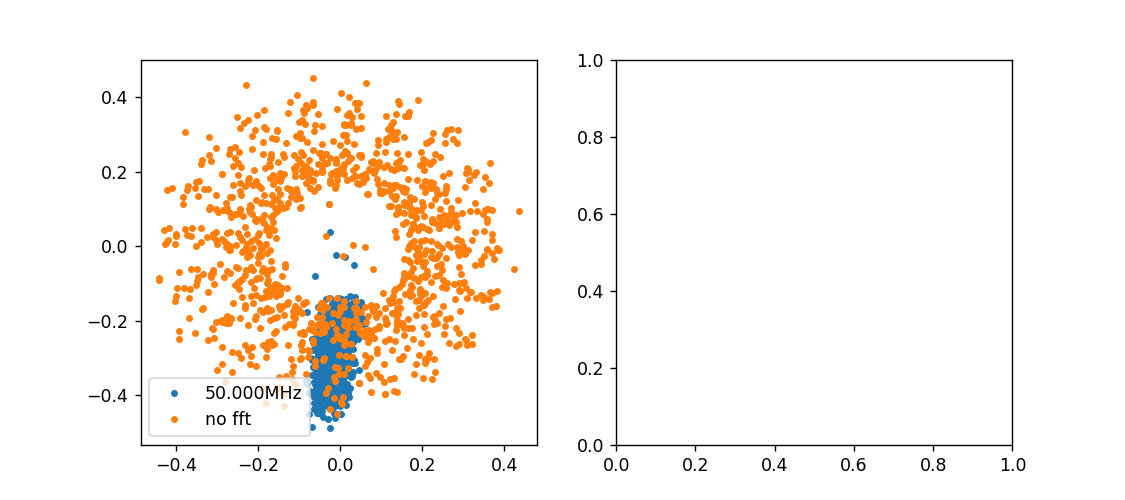

In [32]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=True,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

In [118]:
f = np.mat(np.eye(10)).I * np.mat([1,0,0,0,0,0.5,0,0,0,0]).T
f[5,0]

0.5

In [112]:
f = {'1':1,'2':3}
for i,j in enumerate(f):
    print(i,j)

0 1
1 2


## 时域信号

<IPython.core.display.Javascript object>


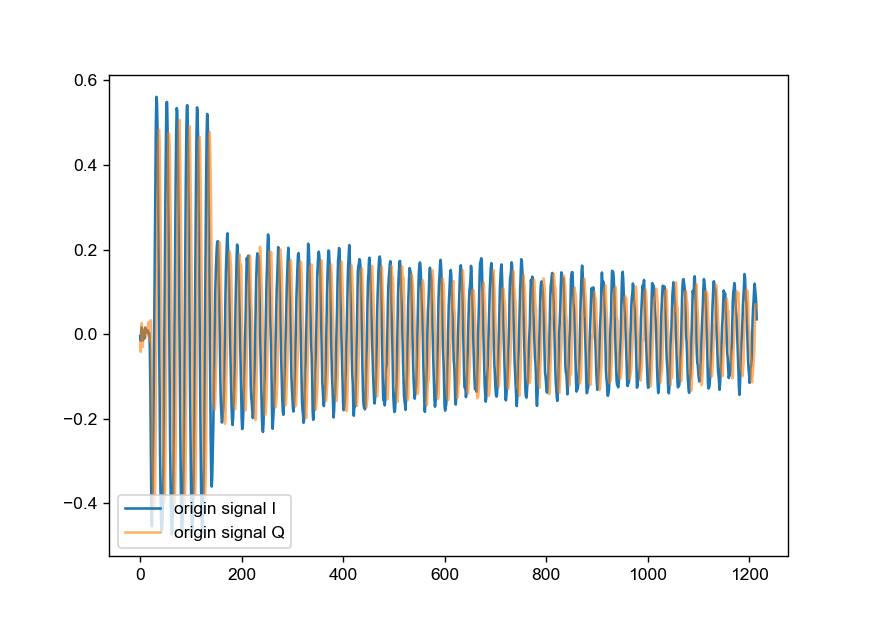

In [770]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex2'].setValue('Output','OFF')
for i in range(1):
    chA, chB = await ats.getTraces()
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


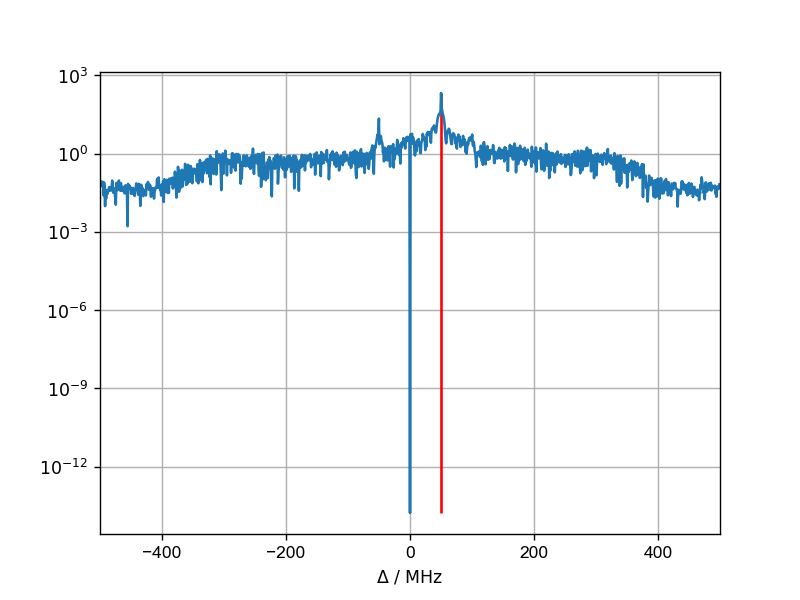

In [771]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

# 仪器状态

In [1051]:
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

In [1063]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

q2      q6     jpa      q1      q3      q8      q7     q10  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        1       0  -0.019   -0.05       0       0       0       0   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

             q4      q5      q9       psg_lo      psg_ex1       psg_ex2  \
error        +0      +0      +0            0            0             0   
freq        NaN     NaN     NaN  6.554940GHz  3.915760GHz   3.931842GHz   
load     high Z  high Z  high Z          NaN          NaN           NaN   
mform       NaN     NaN     NaN          EXT          EXT           EXT   
moutput     NaN     NaN     NaN            0            0             0   
offset        0       0       0          NaN          NaN           NaN   
output      NaN     NaN     NaN            1            0             0   
power       NaN     NaN     NaN  5.000000dBm  6.000000dBm  10.000000dBm   

              psg_ex3      psg_pump    psg_trans  
error               0            +0            0  
freq      4.012900GHz  12.602000GHz  3.999000GHz  
load              NaN           NaN          NaN  
mform             EXT           INT          EXT  
moutput             0             0            1  
offset            NaN           NaN          NaN  
output              0             1            0  
power    10.000000dBm  -2.730000dBm  3.000000dBm

In [83]:
await mr.RecoverInst(measure,state)

In [61]:
await psg230.setValue('Output','OFF')

In [247]:
await psg230.setValue('Power',13)

In [201]:
measure.delta,measure.base,measure.readlen = q1.state[1:]
await mr.RecoverInst(measure,state=q1.state[0])

In [129]:
await psg_ex2.setValue('Output','OFF')

In [328]:
await psg_ex3.setValue('Power',-20)

In [489]:
await psg_lo.setValue('Power',5)

In [49]:
for i in range(100):
    await psg_lo.query('syst:err?')

In [9]:
for i in dc:
    await dc[i].setValue('Load','High')

In [30]:
qname = ['testI','testQ']
awg = awg133
l = 64*10
length = l*2.5
t_new = np.linspace(-l,0,length)*1e-9
await awg.create_waveform(name=qname[0], length=len(t_new), format=None)
await awg.create_waveform(name=qname[1], length=len(t_new), format=None)
await awg.use_waveform(name=qname[0],ch=5)
await awg.use_waveform(name=qname[1],ch=6)
await mr.ats_setup(ats,delta,l=l)
pulse = await cw.rabiWave(envelopename='cospulse',nwave=1,amp=1,during=(l-400)/2e9,Delta_lo=150e6)
await cw.writeWave(awg,qname,pulse,t_new)
await mr.couldRun(awg)

# S21

In [25]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10],q_target='q3')

com7 open...
last ATT 13.0
now ATT 13.0


Output()

<IPython.core.display.Javascript object>


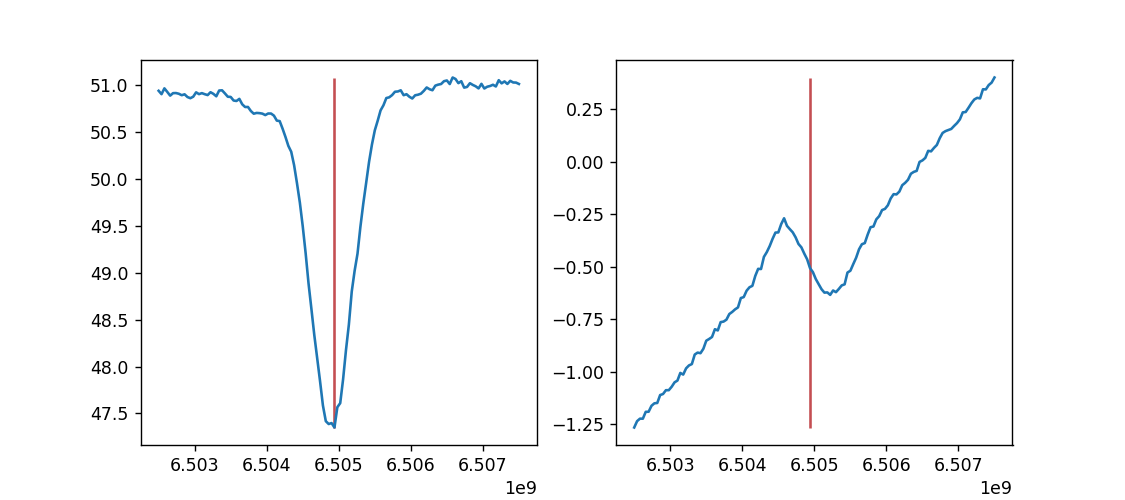

In [1062]:
q_target = q1
tag = q_target.q_name
mr.Att_Setup(measure,'com7').Att(13)
await mr.jpa_switch(measure,state='ON')
f_lo, delta, n, f_res,base,f_s21, s_s21 = await mr.again(q_target,measure,True,measure.f_lo)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

com7 open...
last ATT 12.0
now ATT 12.0


Output()

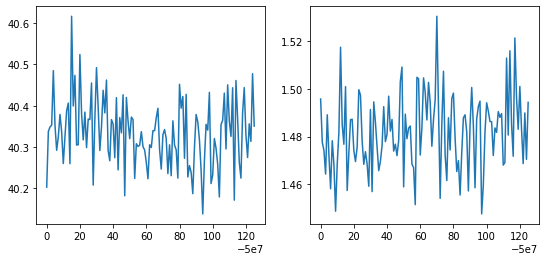

In [19]:
att_setup = mr.Att_Setup(measure,'com7')
att_setup.Att(12)
await psg_lo.setValue('Output','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
await mr.jpa_switch(measure,state='ON')
job = Job(mr.test, (measure,126), tags=[tag], max=126)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

# S21vsFlux

In [10]:
current = np.linspace(-2,2,21)
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
#await dc[bis[0].inst['dc']].DC(1)
for i in bits[:7]:
    tag = i.q_name
    print(tag)
    await mr.jpa_switch(measure,'ON')
    await awg133.output_on(ch=7)
    await awg133.output_on(ch=8)
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mr.S21vsFlux, (qubits,measure,current,1,True), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

q1


Output()

q2


Output()

q3


Output()

q4


Output()

q5


Output()

q6


Output()

q7


Output()

In [ ]:
calimatrix = np.load(r'D:/QuLabData/2020/0401/crosstalk_cali/xue_crosstalk_q2_5_20200401211425.npz')['mat']
calimatrix[1:5,1:5]

In [ ]:
calimatrix = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [ ]:
calimatrix[1:5,1:5]

# S21vsPower

In [ ]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

<IPython.core.display.Javascript object>


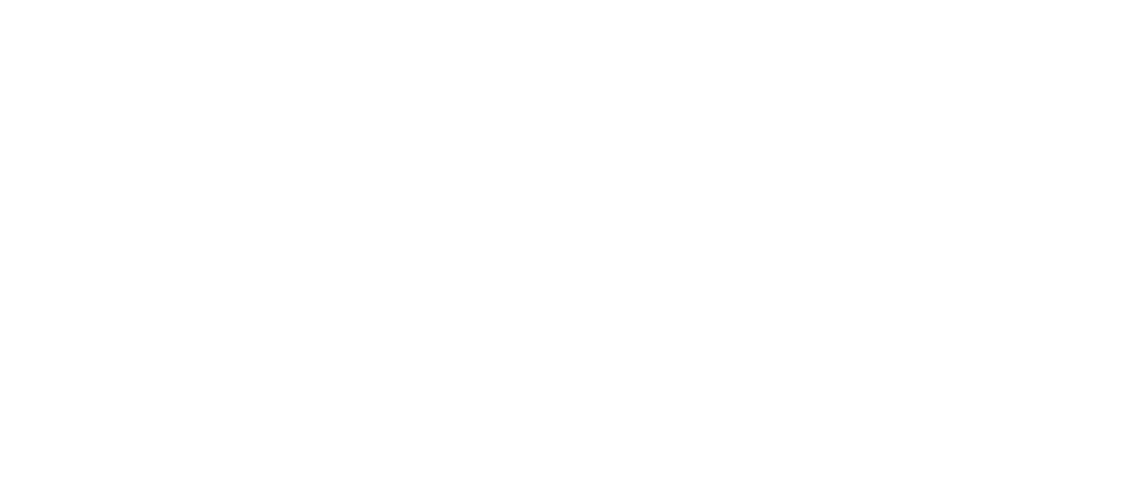

In [481]:
q_target, att = q10, np.linspace(0,20,41)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mr.S21vsPower, (q_target,measure,att,'com7',True), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespce

In [1061]:
q_target = q1
att_single, bias = q_target.power_ex, -0.05
await mr.dcManage(measure,dcstate={q_target.q_name:bias,'q2':1},readstate=[q_target.q_name])

# zname, zch = [''.join((q_target.q_name,'_z'))], q_target.inst['z_ch']
# await cw.genwaveform(measure,measure.awg[q_target.inst['z_awg']],zname,zch)
# await cw.zWave(measure.awg[q_target.inst['z_awg']],zname,zch,during=0)
# await cw.couldRun(measure.awg[q_target.inst['z_awg']])
x = sy.Symbol('x')
f_com = np.float(q_target.specfunc.evalf(subs={x:bias}))
print(round(f_com,3))

3.87


com8 open...
last ATT 25.0
now ATT 25.0


Output()

<IPython.core.display.Javascript object>


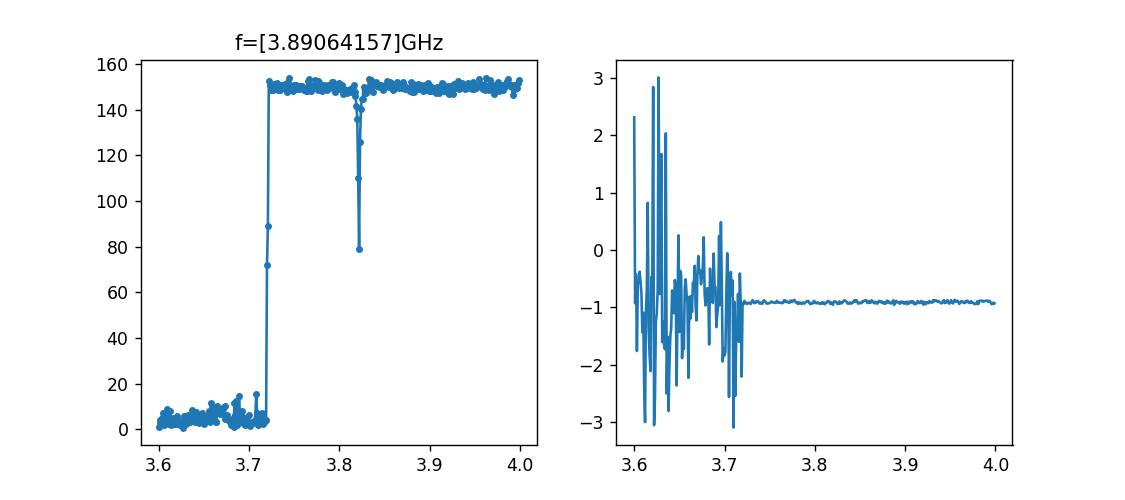

[(3.8906415736530575, 870.907674881518)]


In [1044]:
tag, freq = q_target.q_name, np.arange(-200,201,1)*1e6+round(f_com,3)*1e9
freq = np.arange(3.6,4,0.001)*1e9
await psg_trans.setValue('Power',3)
mr.Att_Setup(measure,'com8').Att(25)
await cw.modulation_ex(q_target,measure)
await mr.jpa_switch(measure,'ON')
job = Job(mr.singlespec, (q_target,measure,freq,True,measure.f_lo,True), tags=[tag], max=len(freq))
f_ss, s_ss = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
x,y,z,band= f_ss/1e9, s_ss,[],[]
for i in range(np.shape(s_ss)[1]):
    try:
        a,b,c,d,e,f = op.Lorentz_Fit().fitLorentz(x[:,i],np.abs(y[:,i]))
        z.append(a/(1.0+c*(x[:,i]-b)**2)+d)
        band.append((b,e))
    except:
        pass
z = np.array(z).T
f_rabi = np.array([x[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
# axes[0].plot(x,z)
axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
print(band)
axes[1].plot(x,np.angle(y))
plt.show()

In [62]:
(3.897-3.76)*2

0.274

In [976]:
q1 = q1._replace(bias=bias,f_ex=np.array([3.822e9]),delta_ex=np.array([110e6]),state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

q2      q6     jpa      q1      q3      q8      q7     q10  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        1       0  -0.019   -0.05       0       0       0       0   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

             q4      q5      q9       psg_lo      psg_ex1       psg_ex2  \
error        +0      +0      +0            0            0             0   
freq        NaN     NaN     NaN  6.580460GHz  3.915760GHz   3.932062GHz   
load     high Z  high Z  high Z          NaN          NaN           NaN   
mform       NaN     NaN     NaN          EXT          EXT           EXT   
moutput     NaN     NaN     NaN            0            0             0   
offset        0       0       0          NaN          NaN           NaN   
output      NaN     NaN     NaN            1            0             1   
power       NaN     NaN     NaN  5.000000dBm  6.000000dBm  10.000000dBm   

              psg_ex3      psg_pump    psg_trans  
error               0            +0            0  
freq      4.012900GHz  12.602000GHz  3.999000GHz  
load              NaN           NaN          NaN  
mform             EXT           INT          EXT  
moutput             0             0            1  
offset            NaN           NaN          NaN  
output              0             1            0  
power    10.000000dBm  -2.730000dBm  3.000000dBm

In [455]:
q10

qubit(q_name='q10', inst={'dc': 'dc10', 'z_awg': 'awg131', 'z_ch': 8, 'ex_awg': 'awg132', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex2', 'com': 'com9'}, T_bias=[2.039, 0.056], specfunc=-93.2181910291993*cos(0.0733463105673384*pi*x + 3.124208850395) - 89.3095042728714, bias=-0.1, zpulse=None, f_lo=[6629000000.0], delta=array([50000000.]), f_ex=array([3.8918e+09]), delta_ex=array([1.1e+08]), alpha=272000000.0, power_ex=60, power_rabi=27, pi_len=21, T1=None, state=[{'q2': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q6': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'jpa': {'offset': -0.019, 'load': 'high Z', 'error': '+0'}, 'q1': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q3': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q8': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q7': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q10': {'offset': -0.1, 'load': 'high Z', 'error': '+0'}, 'q4': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'q5': {'offset': 0.0, 'load': 'h

In [456]:
q10 = q10._replace(inst={'dc': 'dc10', 'z_awg': 'awg131', 'z_ch': [8], 'ex_awg': 'awg132', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex2', 'com': 'com9'},delta_ex=np.array([80e6]),power_ex=60)

In [33]:
t = time.strftime('%y%m%d%H%M%S') 

'200517162754'

In [494]:
q5 = q5._replace(f_ex=np.array([3.926e6]),bias=-0.107)

## 单条谱扫电压

com13 open...
last ATT 30.0
now ATT 60.0


Output()

<IPython.core.display.Javascript object>


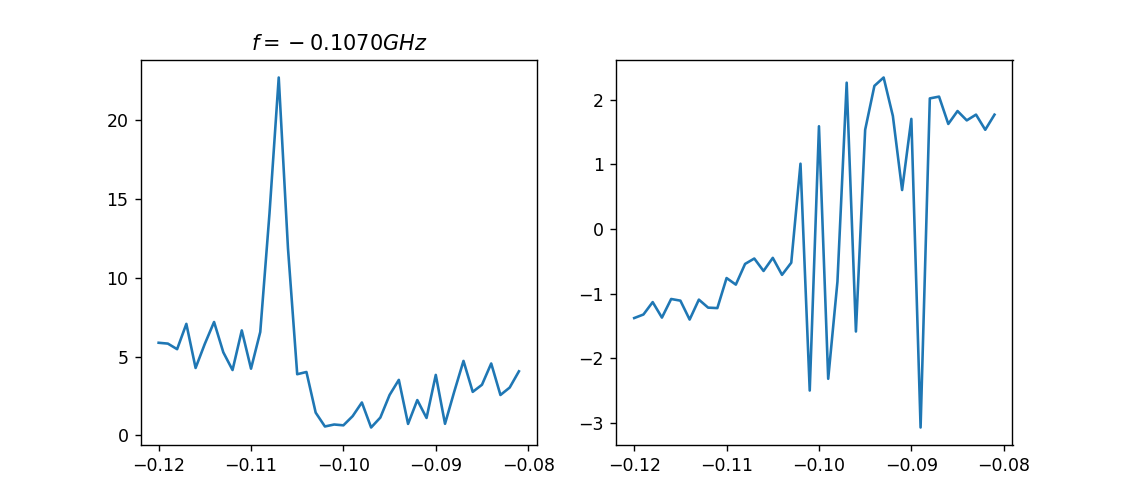

In [415]:
tag, ftarget, biaslist = q_target.q_name, 3.926e9, np.arange(-0.02,0.02,0.001) + bias

att_setup = mr.Att_Setup(measure,q_target.inst['com'])
att_setup.Att(q_target.power_ex)
await cw.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.specbias, (q_target,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(v_rabi[0]))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# Rabi

In [1020]:
q_target = q1
# if q_target.inst['ex_lo'] == 'psg_ex2':
#     t_rabi = np.linspace(1,801,201)
#     att_single = 5
#     await psg_ex1.setValue('Output','OFF')
# else:
#     t_rabi = np.linspace(1,1001,201)
#     att_single = 0
#     await psg_ex2.setValue('Output','OFF')
t_rabi = np.linspace(1,201,201)
att_single = 35

com10 open...
last ATT 35.0
now ATT 35.0


Output()

<IPython.core.display.Javascript object>


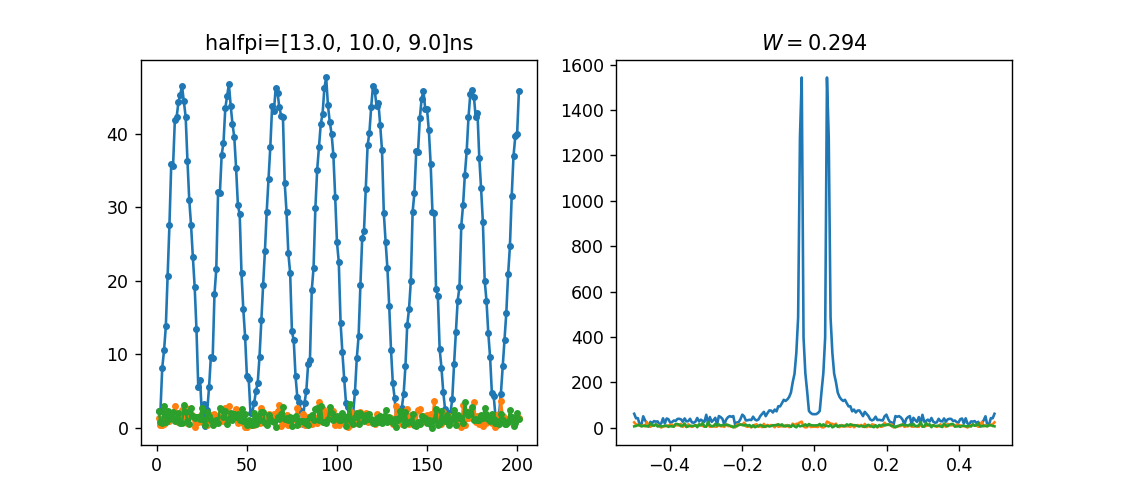

In [1021]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex2.setValue('Power',10)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
for i in range(1):
    await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)),awg=1)
    job = Job(mr.rabi, (q_target,measure,t_rabi,True,1,1), tags=[tag], max=500,avg=True)
    t_r, s_r = await job.done()
    state = await mr.QueryInst(measure)
    index = np.abs(s_r).argmax(axis=0)
    t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
    fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
    t_op = []
    for i in range(np.shape(s_r)[1]):
        x, y = t_r[:,i], np.abs(s_r[:,i])
        t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
        sample = (np.max(x) - np.min(x))/(len(x) - 1)
        yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
        amp = np.fft.fftshift(np.fft.fft(y))

        axes[0].plot(x,y,'-o',markersize=3)
        axes[0].set_title(f'halfpi={t_op}ns')
        axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
        axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
    plt.show()

In [1022]:
q1 = q1._replace(pi_len=13,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

q2      q6     jpa      q1      q3      q8      q7     q10  \
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        1       0  -0.019   -0.05       0       0       0       0   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

             q4      q5      q9       psg_lo      psg_ex1       psg_ex2  \
error        +0      +0      +0            0            0             0   
freq        NaN     NaN     NaN  6.580500GHz  3.915760GHz   3.931842GHz   
load     high Z  high Z  high Z          NaN          NaN           NaN   
mform       NaN     NaN     NaN          EXT          EXT           EXT   
moutput     NaN     NaN     NaN            0            0             0   
offset        0       0       0          NaN          NaN           NaN   
output      NaN     NaN     NaN            1            0             1   
power       NaN     NaN     NaN  5.000000dBm  6.000000dBm  10.000000dBm   

              psg_ex3      psg_pump    psg_trans  
error               0            +0            0  
freq      4.012900GHz  12.602000GHz  3.999000GHz  
load              NaN           NaN          NaN  
mform             EXT           INT          EXT  
moutput             0             0            1  
offset            NaN           NaN          NaN  
output              0             1            0  
power    10.000000dBm  -2.730000dBm  3.000000dBm

In [253]:
await psg_ex3.query('syst:err?')

'0,"No error"\n'

# pi脉冲振幅

In [1075]:
q_target = q1
t_rabi = np.linspace(1,501,201)
att_single = 35

In [ ]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseAmp, (q_target,measure,t_rabi), tags=[tag], max=9)
amp_pi, t_amp, s_amp = await job.done()
state = await mr.QueryInst(measure)
x, y , s = amp_pi[:,0], t_amp[0][:,0], s_amp[:,:,0]
wlist = [((op.RowToRipe().fourier(y,np.abs(i)))[0]) for i in s]
t_op = op.RowToRipe().firstMax(y,np.abs(s[-1]),num=0,peakpercent=0.7)
a = np.polyfit(x,wlist,1)
z = np.poly1d(a)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].set_yticks(x)
axes[1].plot(x,wlist,'.')
axes[1].plot(x,z(x))
axes[1].set_title(f'$grad={a[0]}$')
plt.show()

com10 open...
last ATT 38.0
now ATT 35.0


Output()

(201,)

# rabi_waveform

com12 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


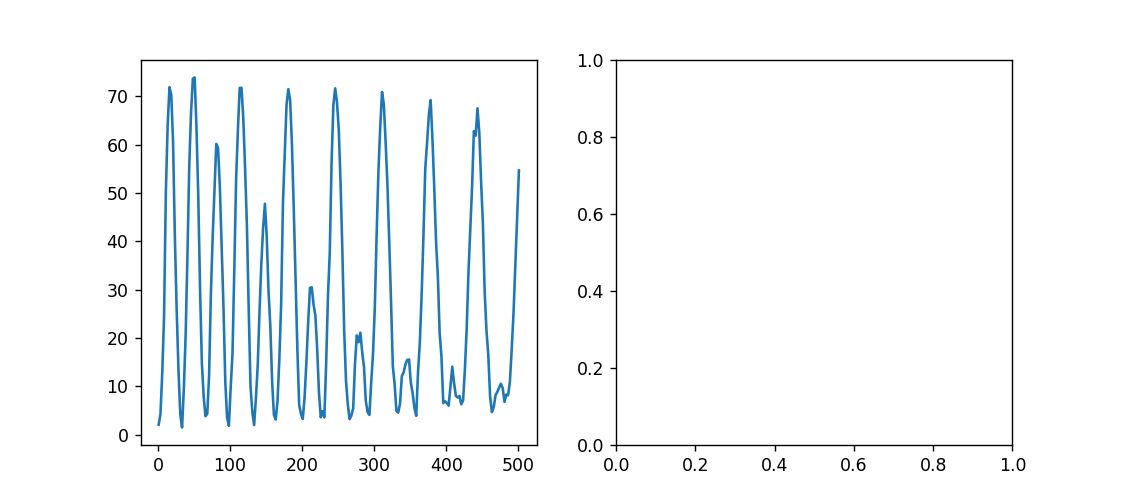

In [25]:
t_rabi, q_target, which = np.linspace(1,501,201), q3, 1
att_single = 20
if q_target.inst['ex_lo'] == 'psg_ex2':
    await psg_ex1.setValue('Output','OFF')
else:
    await psg_ex2.setValue('Output','OFF')
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex+220e6)[0])
job = Job(mr.Rabi_waveform, (q_target,measure,t_rabi,1), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

# rabiPower

com13 open...
DS Instruments,DAT64H,372,V9.10
last ATT 10.0
now ATT 05.0


Output()

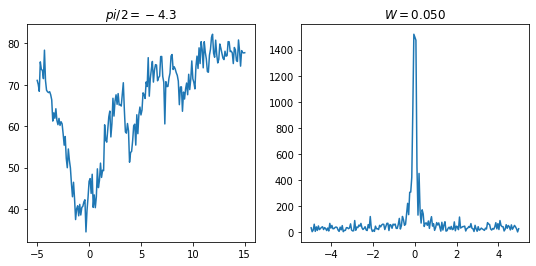

In [117]:
amplitude, q_target = np.linspace(0.2,1,201), q5
att_single = 40
mr.Att_Setup(q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabi, (q_target,measure,10,True,amplitude,1), tags=[tag], max=500,avg=True)
t_rp, s_rp = await job.done()
state = await mr.QueryInst(measure)

for i in range(np.shape(s_rp)[1]):
    x, y = t_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    sample = (np.max(x) - np.min(x))/(len(x) - 1)
    yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
    amp = np.fft.fftshift(np.fft.fft(y))

    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].set_title(f'power={t_op}ns')
#     axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
#     axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [ ]:
q3 = q3._replace(pi_len=20,power_rabi=t_op,state=[state,measure.delta,measure.base,measure.readlen])

# Readout point

com7 open...
last ATT 13.0
now ATT 13.0
com10 open...
last ATT 35.0
now ATT 35.0


Output()

<IPython.core.display.Javascript object>


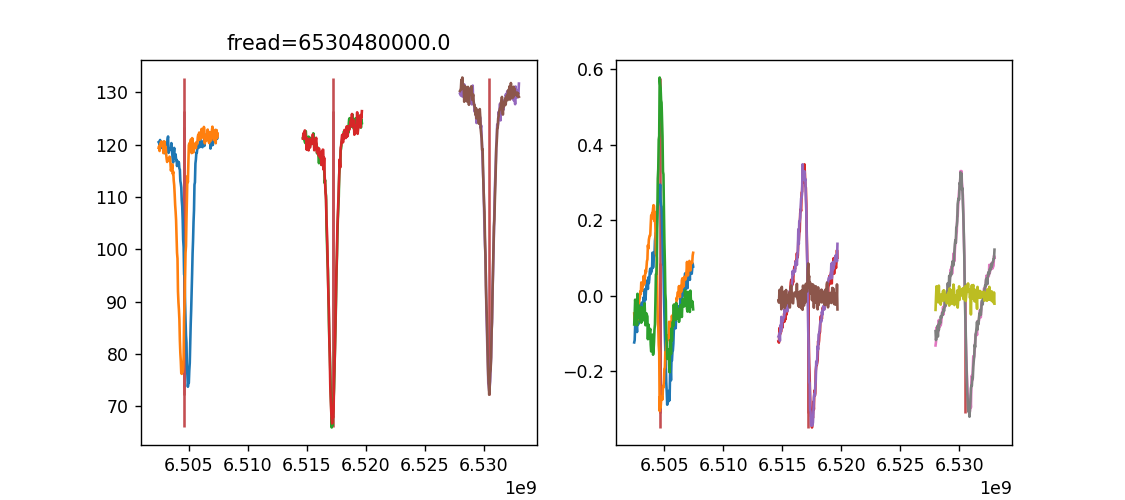

In [1023]:
q_target = q1
mr.Att_Setup(measure,'com7').Att(13)
att_setup = mr.Att_Setup(measure,q_target.inst['com'])
att_setup.Att(q_target.power_rabi)
await mr.jpa_switch(measure,state='ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.readOp, (q_target,measure,True,measure.f_lo), tags=[q_target.q_name], max=2)
st, f_op, s_op = await job.done()
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mr.resn(np.array(f_lo))
axes[0].set_title(f'fread={f_lo-50e6}')
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
await psg['psg_lo'].setValue('Frequency',f_lo)

In [1015]:
f_lo - measure.delta

array([6.50464e+09, 6.51720e+09, 6.53052e+09])

In [1013]:
measure.delta 

array([75880000., 63320000., 50000000.])

In [1014]:
await ats.getValue('f_list')

array([75880000., 63320000., 50000000.])

# 优化读出长度

Output()

<IPython.core.display.Javascript object>


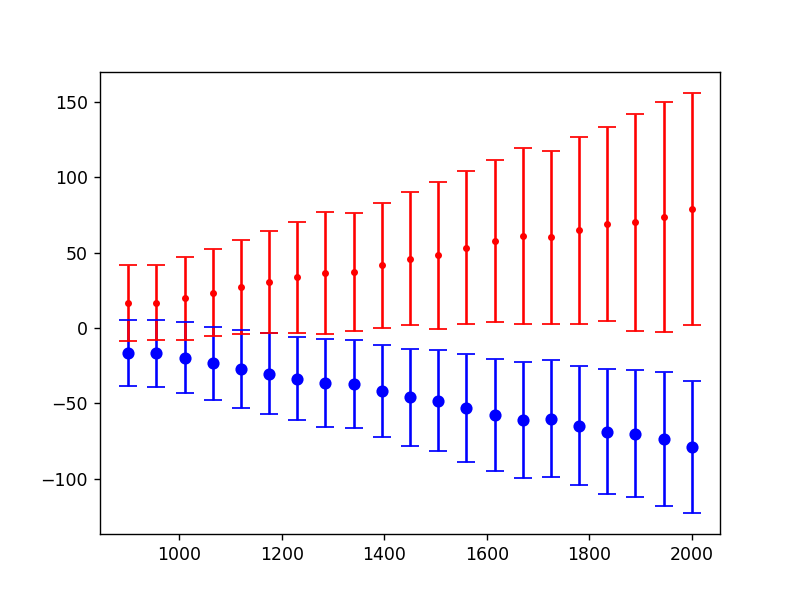

In [71]:
# await measure.psg['psg_lo'].setValue('Power',13)
# mr.Att_Setup(measure,'com7').Att(13)
job = Job(mr.readWavelen, (q_target,measure), tags=[tag], max=21)
wl, s_wl = await job.done()
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

In [251]:
4*np.sqrt(np.log(2))

3.3302184446307908

In [ ]:
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

# 临界线

In [1033]:
measure.readlen = 1600

com7 open...
last ATT 12.0
now ATT 13.0


Output()

<IPython.core.display.Javascript object>


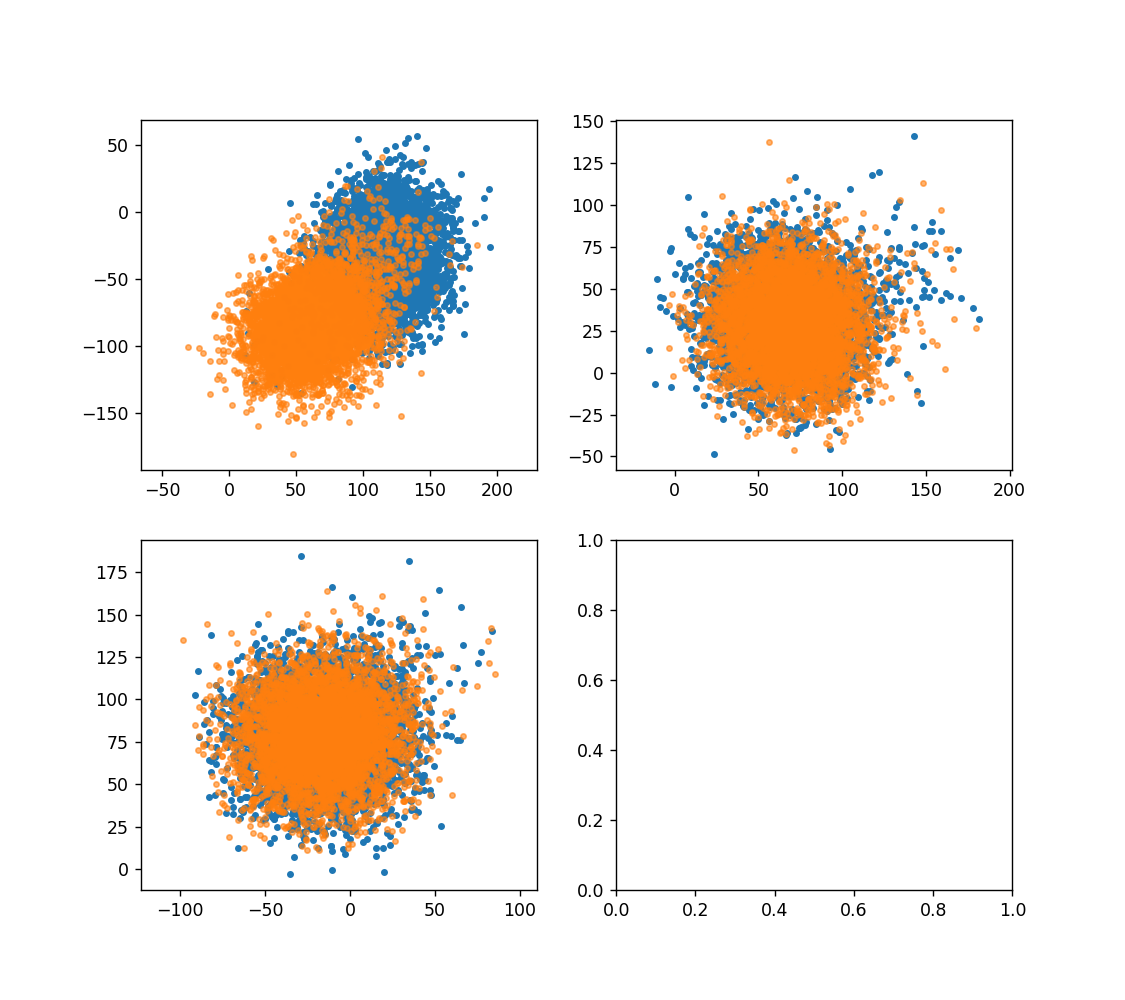

In [1035]:
q_target = q1
# await measure.psg['psg_lo'].setValue('Power',13)
mr.Att_Setup(measure,'com7').Att(13)
job = Job(mr.threshHold, (q_target,measure,True), tags=[q_target.q_name], max=2)
st, s_st = await job.done()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


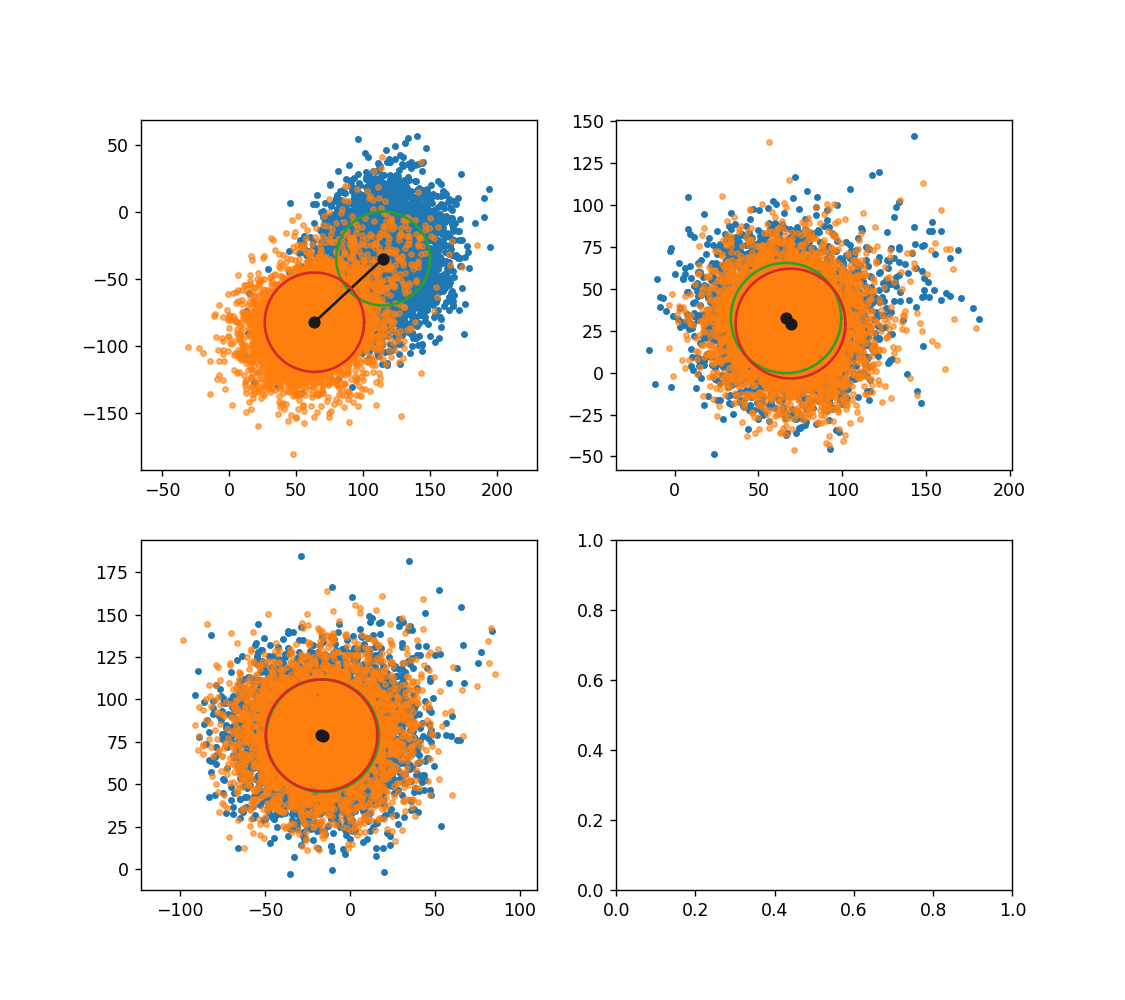

In [1036]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    offmean, onmean = np.mean(x), np.mean(y)
    offstd, onstd = np.std(x), np.std(y)
    theta = np.arange(0, 2*np.pi, 0.01)
    roff = np.real(offmean) + offstd * np.cos(theta)
    ioff = np.imag(offmean) + offstd * np.sin(theta)
    ron = np.real(onmean) + onstd * np.cos(theta)
    ion = np.imag(onmean) + onstd * np.sin(theta)
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
    ax.plot(roff,ioff)
    ax.plot([np.real(offmean),np.real(onmean)],[np.imag(offmean),np.imag(onmean)],'k-o')
    ax.plot(ron,ion)
plt.show()

In [1025]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
    s_off, s_on = (x-add)/diff, (y-add)/diff
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


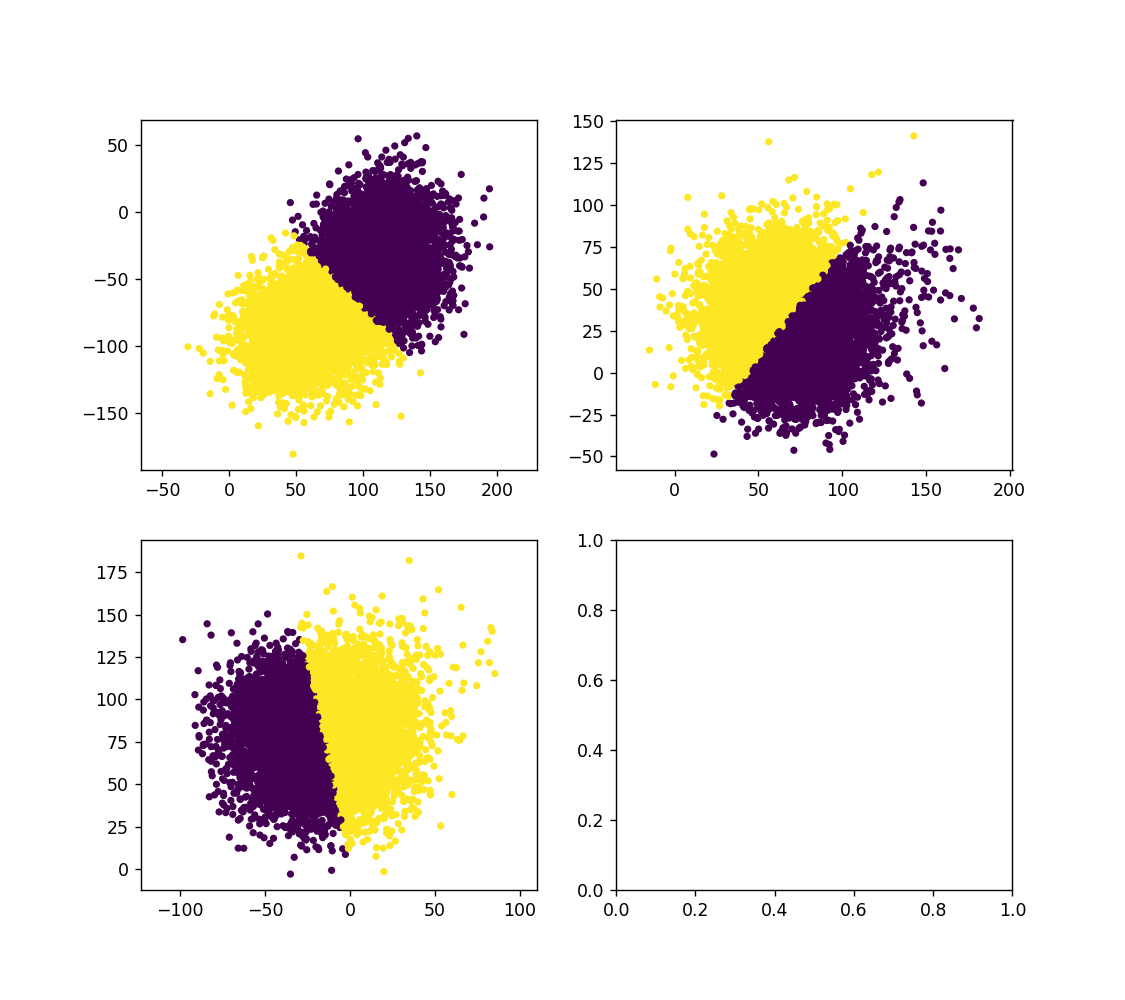

0.48813291139240506
0.49149525316455694
0.4854628164556962


In [1037]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
predict = []
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict.append(kmeans.predict)
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

<IPython.core.display.Javascript object>


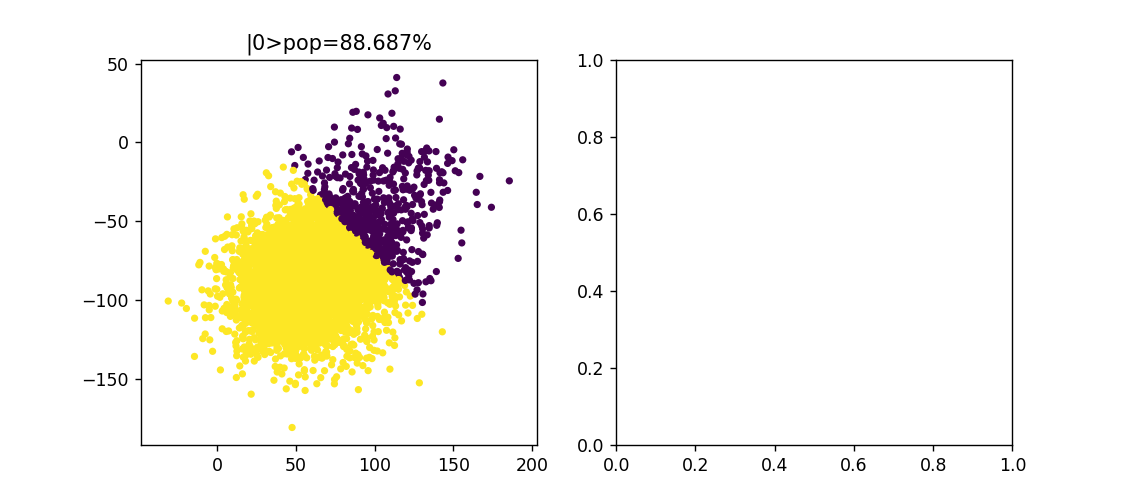

In [1066]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
onwhich = offwhich = []
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[i](d)
    percent = list(y).count(which)/len(y)
    onwhich.append(which if percent > 0.5 else 1-which)
    offwhich.append(1-which if percent > 0.5 else which)
    percent = list(y).count(onwhich[i])/len(y)
    
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

# rabiPopulation

com13 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


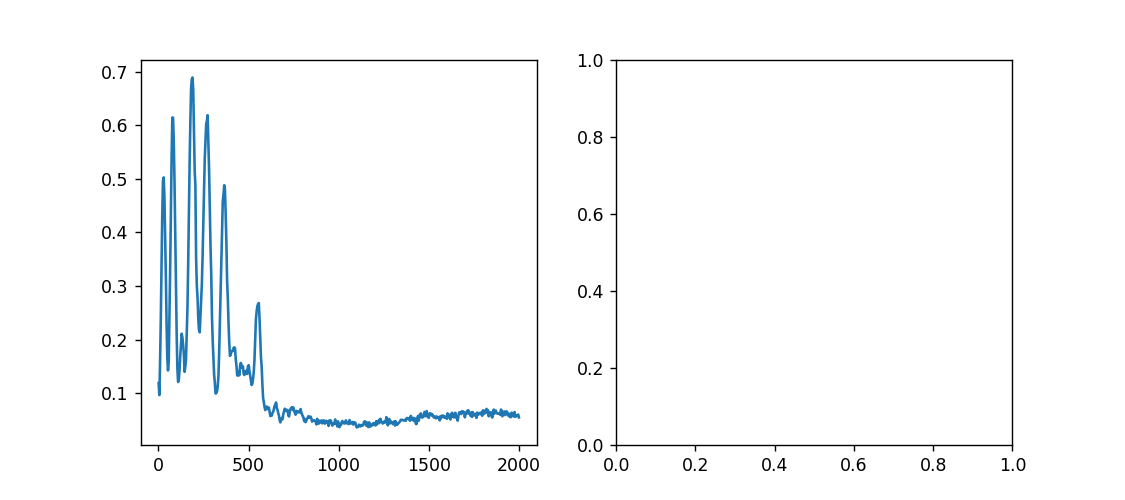

In [98]:
t_rabi, q_target, which = np.linspace(1,2001,501), q3, 1
att_single = 20
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex2.setValue('Output','OFF')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPop, (q_target,measure,t_rabi,which), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

0.10700158227848101


<IPython.core.display.Javascript object>


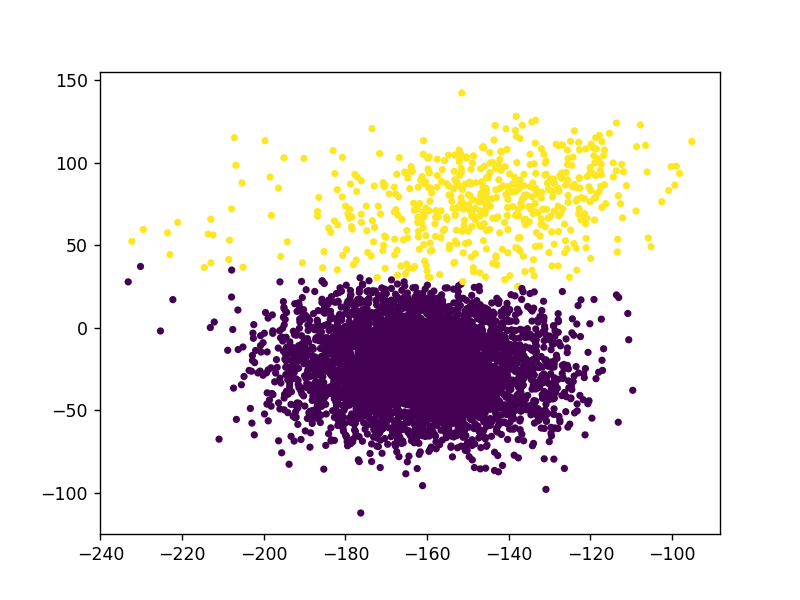

In [148]:
ss, which = pop[4,:,0], 1
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# 优化读出功率

Output()

<IPython.core.display.Javascript object>


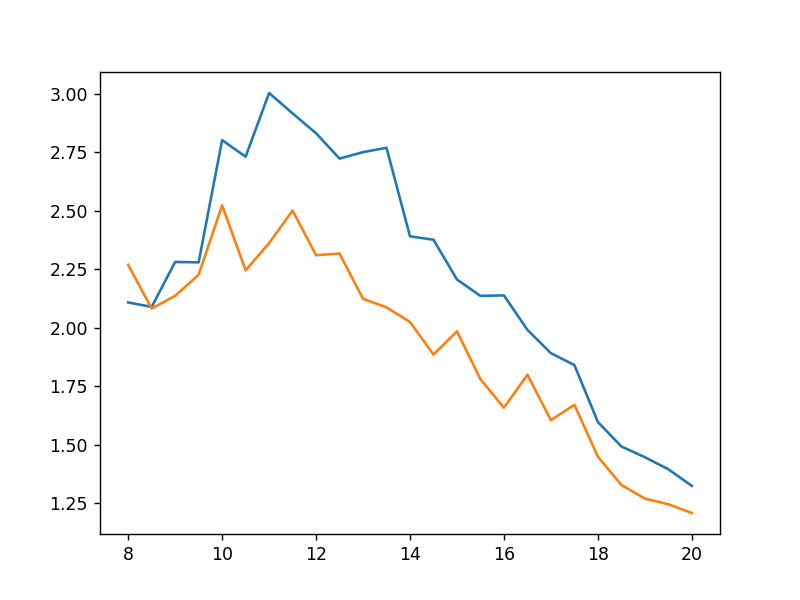

In [596]:
com, att = 'com7', np.linspace(8,20,25)
job = Job(mr.readpowerOpt, (q_target,measure,com,att), tags=[tag], max=len(att))
attopt, popoff, popon = await job.done()
plt.figure()
plt.plot(attopt,popoff)
plt.plot(attopt,popon)
plt.show()

# pi脉冲优化

## sequance

<IPython.core.display.Javascript object>


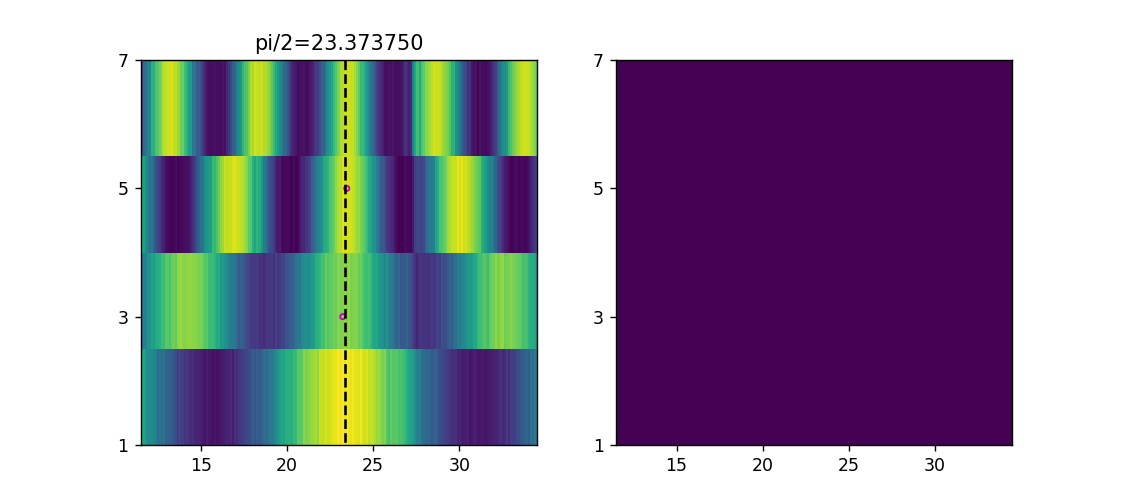

In [691]:
# q_target, nwave, wavlen = q1, 4, len(t_rabi)
# tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
# job = Job(mr.pipulseOpt, (q_target,measure,nwave,wavlen), tags=[tag], max=nwave)
# n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=q_target.pi_len,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

In [692]:
q1 = q1._replace(pi_len=23.37,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

## waveform

Output()

<IPython.core.display.Javascript object>


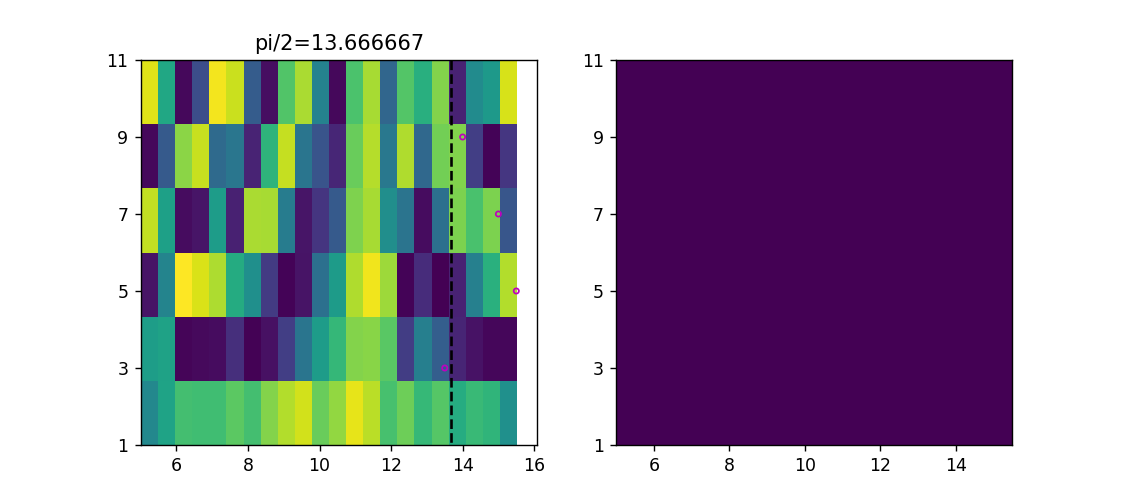

In [100]:
q_target, nwave, wavlen = q3, 6, len(t_rabi)
tag = q_target.q_name
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt_waveform, (q_target,measure,nwave), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=16,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

# pipulseDetune

Output()

Output()

<IPython.core.display.Javascript object>


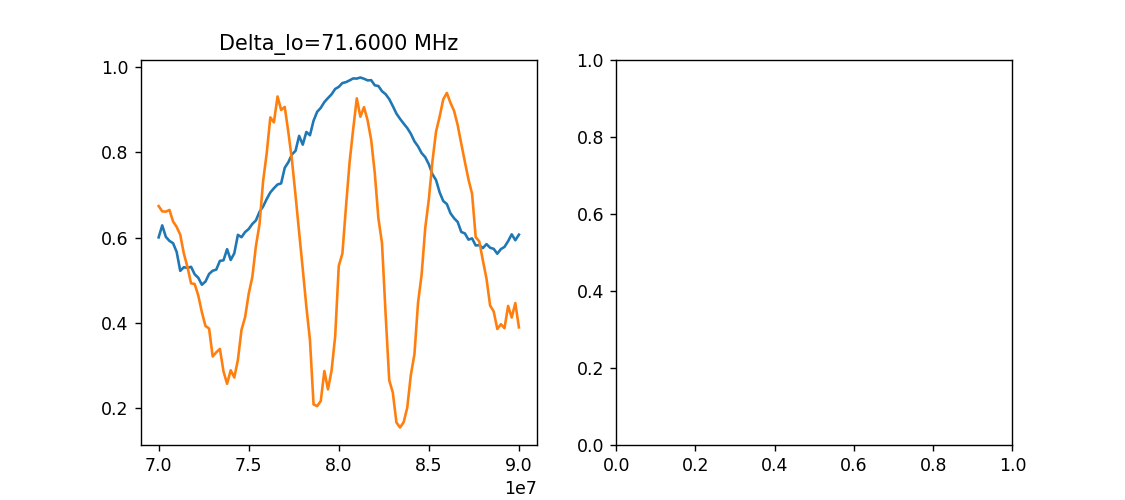

In [204]:
q_target, which = q3, measure.offwhich
alpharatiodelta = -1/ q_target.alpha / (2*np.pi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
popn = []
for i in (1,5):
    job = Job(mr.detuneOpt, (q_target,measure,which,alpharatiodelta,i), tags=[q_target.q_name], max=101)
    f_op, pop = await job.done()
    popn.append(pop)
x, y1, y2 = f_op[:,0], popn[0][:,0], popn[1][:,0]
# f01 = op.RowToRipe().firstMax(x,y,num=(q_target.f_ex+q_target.delta_ex)[0],peakpercent=0.7)
index = np.argmin(np.abs(y1-y2))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y1))
axes[0].plot(x,np.abs(y2))
axes[0].set_title('Delta_lo=%.4f MHz'%((x[index])/1e6))
plt.show()

In [ ]:
x, y1, y2 = f_op[:,0], popn[0][:,0], popn[1][:,0]
# f01 = op.RowToRipe().firstMax(x,y,num=(q_target.f_ex+q_target.delta_ex)[0],peakpercent=0.7)
index = np.argmin(np.abs(y1-y2))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y1))
axes[0].plot(x,np.abs(y2))
axes[0].set_title('Delta_lo=%.4f MHz'%((x[index])/1e6))
plt.show()

# IQ-Mixer优化相位

Output()

<IPython.core.display.Javascript object>


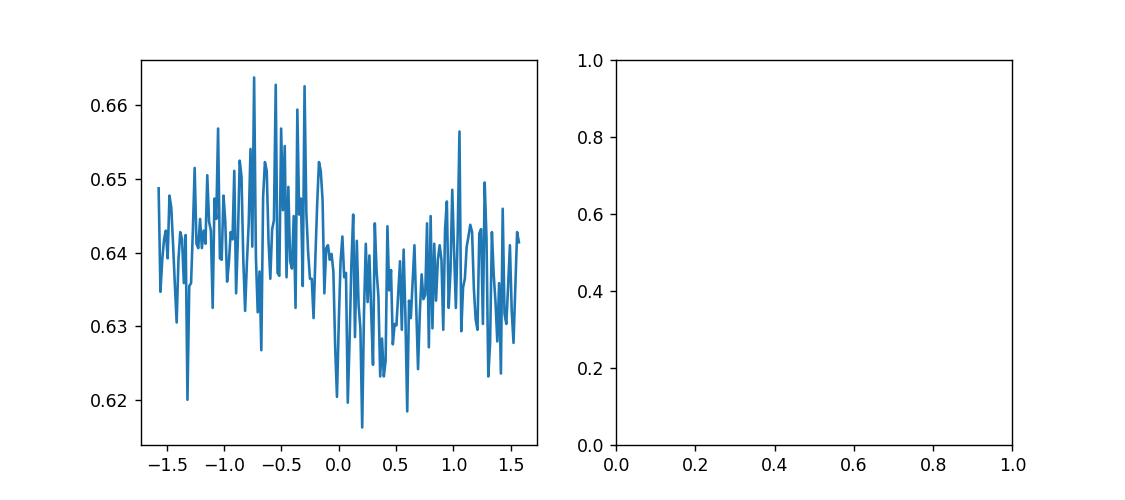

In [129]:
q_target, which = q3, 1
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.IQphaseOpt, (q_target,measure,which), tags=[tag], max=201)
phase_op, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(phase_op[:,0],np.abs(pop[:,0]))
plt.show()

In [84]:
await psg_ex1.setValue('Frequency',4.0576e9)

In [290]:
qubit = q5
name, awg_target = [qubit.q_name+'_I', qubit.q_name+'_Q'], measure.awg[qubit.inst['ex_awg']]
await cw.genwaveform(measure,awg_target,name,qubit.inst['ex_ch'])
await cw.modulation_read(measure,measure.delta,tdelay=measure.readlen)
await measure.psg[qubit.inst['ex_lo']].setValue('Frequency',(qubit.f_ex)[0])
await measure.psg['psg_lo'].setValue('Output','ON')
ch1, ch2 = qubit.inst['ex_ch']
    
async def awgoffset(offset1,offset2):
    await awg_target.stop()
    await awg_target.setValue('Offset',offset1,ch=ch1)
    await awg_target.setValue('Offset',offset2,ch=ch2)
    await cw.couldRun(awg_target)
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','ON')
    ch_A, ch_B = await measure.ats.getIQ()
    Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
    theta0 = np.angle(Am) - np.angle(Bm)
    Bm *= np.exp(1j*theta0)
    s = Am + Bm
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','OFF')
    return np.abs(s - measure.base)

In [292]:
# await cw.ats_setup(ats18,np.array([50e6]),l=1500,repeats=500)
opt.optimize(awgoffset,[-0.1,-0.5],[0.01,0.01],[3,3],high=[2,2],low=[-2,-2],print_info=True,algorithm='minimize')

.o
[-0.1 -0.5] [60.0750074]   .o
[-0.09 -0.5 ] [58.95595297]   .o
[-0.1  -0.49] [57.30026133]   ..............o
[-0.099 -0.491] [57.24198258]   ..................
 CacheInfo(hits=17, misses=18, maxsize=128, currsize=18)


 final_simplex: (array([[-0.09875   , -0.49125   ],
       [-0.09882813, -0.49117187],
       [-0.09876953, -0.49119141]]), array([57.24198258, 57.24198258, 57.24198258]))
           fun: 57.241982575449434
       message: 'Optimization terminated successfully.'
          nfev: 35
           nit: 11
        status: 0
       success: True
             x: array([-0.099, -0.491])

# AllXY dragdetune

Output()

<IPython.core.display.Javascript object>


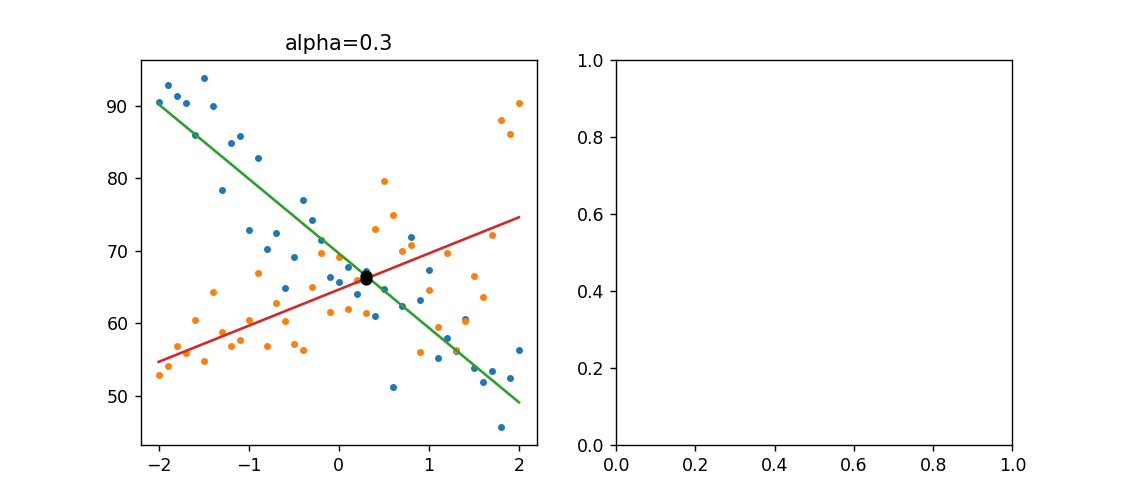

In [737]:
q_target, which = q1, 0
alpha = q_target.alpha*2*np.pi

await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.AllXYdragdetune, (q_target,measure,which,alpha), tags=[tag], max=82)
fall, sall = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(fall)[0]//2
f1, f2, s1, s2 = fall[:l,0], fall[l:,0], np.abs(sall[:l,0]), np.abs(sall[l:,0])
z1 = np.poly1d(np.polyfit(f1,s1,1))(f1)
z2 = np.poly1d(np.polyfit(f2,s2,1))(f2)
index = np.argmin(np.abs(z1-z2))
axes[0].plot(np.array([f1,f2]).T,np.array([s1,s2]).T,'.')
axes[0].plot(np.array([f1,f2]).T,np.array([z1,z2]).T)
# axes[0].plot(fall[l:,:],np.abs(sall[l:,:]))
axes[0].plot([f1[index],f2[index]],[z1[index],z2[index]],'ko')
axes[0].set_title(f'alpha={round(f1[index],3)}')
plt.show()

In [97]:
10*np.log10()

(802, 1)

# AC-Stark

Output()

<IPython.core.display.Javascript object>


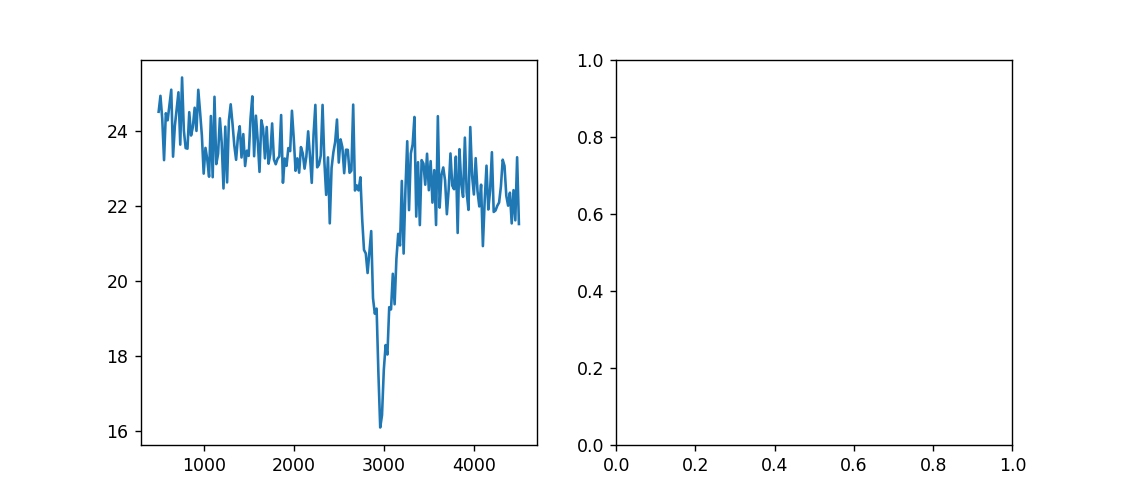

In [320]:
t_ac, q_target = np.linspace(500,4500,201), q10
job = Job(mr.singleacStark, (q_target,measure,t_ac), tags=[q_target.q_name], max=500,avg=True)
t_AC, s_AC = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_AC,np.abs(s_AC))
# axes[1].plot(t_AC,np.angle(s_AC.mean(axis=0)))
plt.show()

In [ ]:
q7 = q7._replace(inst={'dc': 'dc08', 'z_awg': 'awg131', 'z_ch': 7, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'})

In [ ]:
q6

## ZPulse与激励时序

Output()

<IPython.core.display.Javascript object>


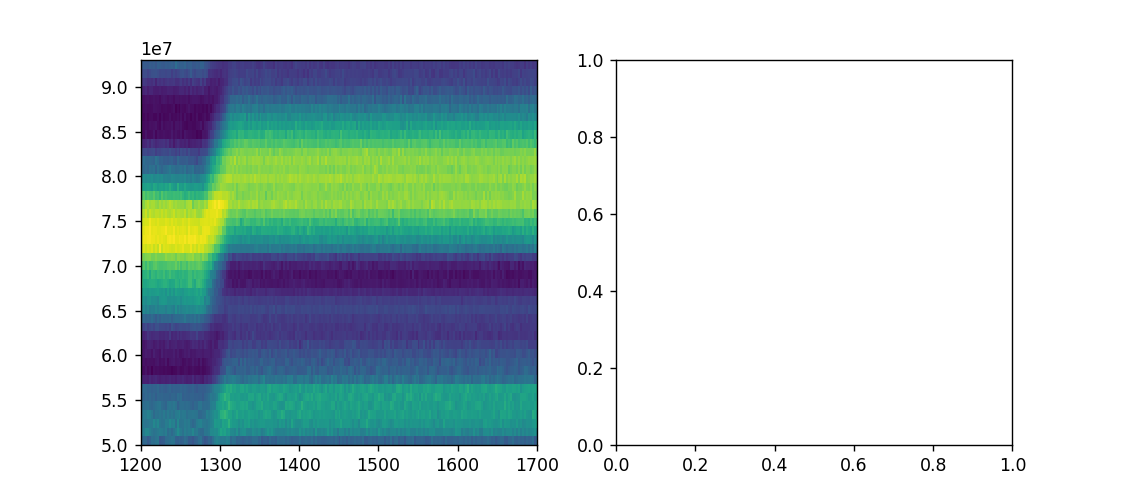

In [320]:
t_z, q_target = np.linspace(1200,1700,201), q3
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.zPulse, (q_target,measure,t_z), tags=[q_target.q_name], max=61)
f_z, t_z, s_z = await job.done()
x, y , s = f_z[:,0], t_z[0][:,0], s_z[:,:,0]
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
plt.show()

## 单条

Output()

<IPython.core.display.Javascript object>


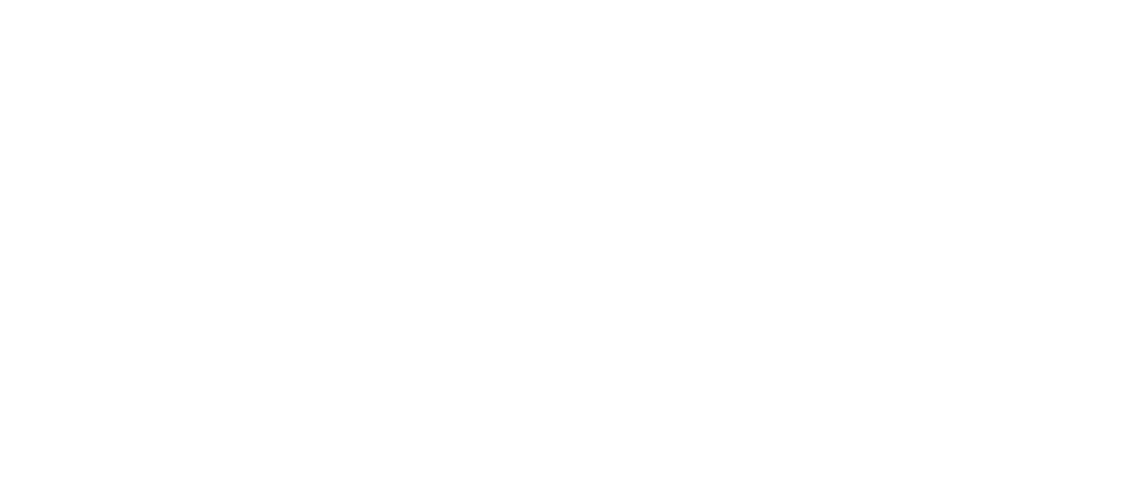

In [468]:
t_z, q_target = np.linspace(0,5000,501), q10
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.singleZpulse, (q_target,measure,t_z,110e6,True), tags=[tag], max=500,avg=True)
t_z, s_z = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_z[:,0],np.abs(s_z[:,0]))
plt.show()

In [73]:
x,y=t_AC[269:305,0],np.abs(pop[269:305,0])
a, b, c, d, e = op.TwoExp_Fit().fitTwoexp(x,y)
z = a*np.exp(b*x) + c*np.exp(d*x) + e 
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].plot(x,z)
plt.show()

d:\qulab\qulab\optimize.py:103: RuntimeWarning: overflow encountered in exp
  return np.sum((A * np.exp(-x*T1) + B - y)**2)
d:\qulab\qulab\optimize.py:103: RuntimeWarning: overflow encountered in multiply
  return np.sum((A * np.exp(-x*T1) + B - y)**2)


(153.53500508637126, 0.0015220600381117115, 30.70700101727425, 0.0003044120076223423, 5.8267137221227525)


d:\qulab\qulab\optimize.py:399: RuntimeWarning: overflow encountered in exp
  return np.sum((a*np.exp(b*x) + c*np.exp(d*x) + e - y)**2)
d:\qulab\qulab\optimize.py:399: RuntimeWarning: overflow encountered in multiply
  return np.sum((a*np.exp(b*x) + c*np.exp(d*x) + e - y)**2)
d:\qulab\qulab\optimize.py:399: RuntimeWarning: invalid value encountered in add
  return np.sum((a*np.exp(b*x) + c*np.exp(d*x) + e - y)**2)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\optimize\_basinhopping.py:313: RuntimeWarning: invalid value encountered in double_scalars
  w = math.exp(min(0, -float(energy_new - energy_old) * self.beta))


# ramseyZpulse

Output()

<IPython.core.display.Javascript object>


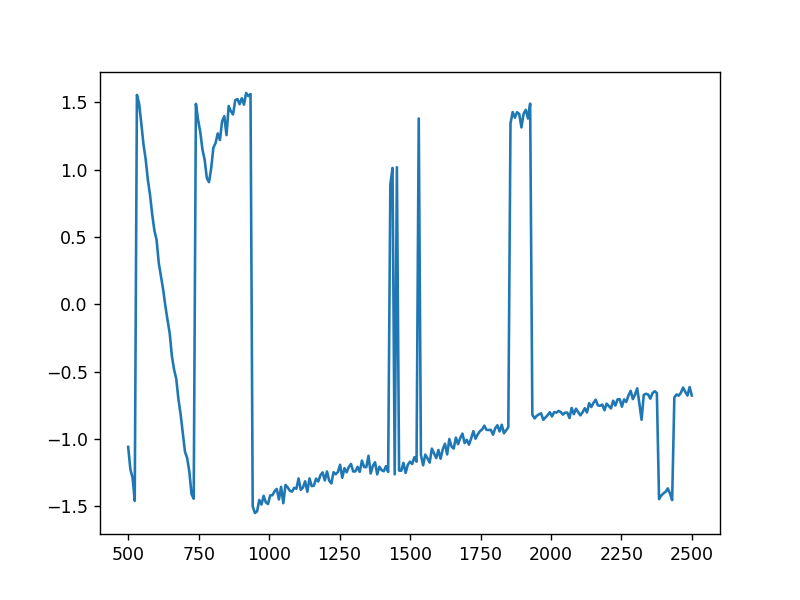

In [313]:
q_target, which, tcali = q3, measure.offwhich, 500
dragcoef = None
tdelay = np.arange(500,2500,(q_target.pi_len/4))
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.ramseyZpulse, (q_target,measure,tdelay,which,tcali,dragcoef), tags=[q_target.q_name], max=len(tdelay))
t_rz, poplist_rz = await job.done()
coordinate = [[1-2*j[i] for i in range(2)] for j in poplist_rz]
theta = np.array([np.arctan(i[1]/i[0]) for i in coordinate])
plt.figure()
plt.plot(t_rz,-theta)
plt.show()

<IPython.core.display.Javascript object>


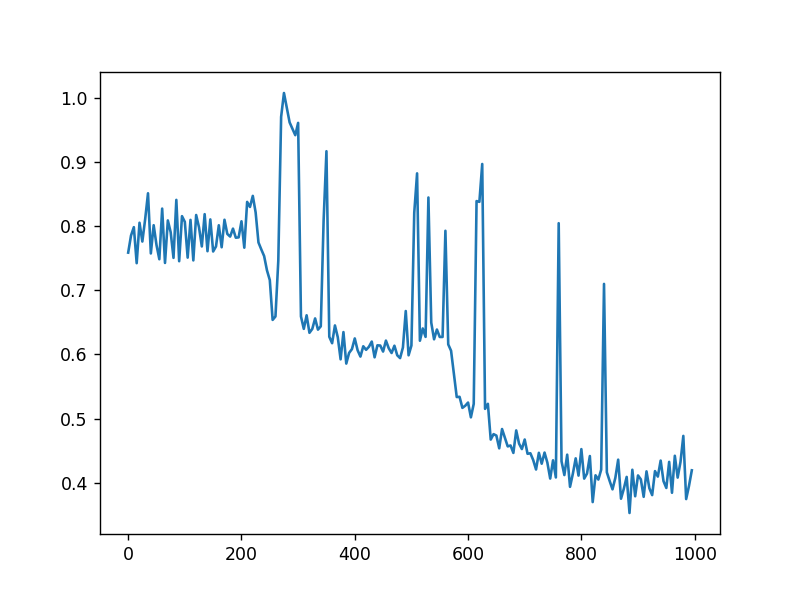

# T1

Output()

d:\qulab\qulab\optimize.py:103: RuntimeWarning: overflow encountered in exp
  return np.sum((A * np.exp(-x*T1) + B - y)**2)
d:\qulab\qulab\optimize.py:103: RuntimeWarning: overflow encountered in square
  return np.sum((A * np.exp(-x*T1) + B - y)**2)
d:\qulab\qulab\optimize.py:103: RuntimeWarning: overflow encountered in multiply
  return np.sum((A * np.exp(-x*T1) + B - y)**2)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\optimize\optimize.py:596: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


<IPython.core.display.Javascript object>


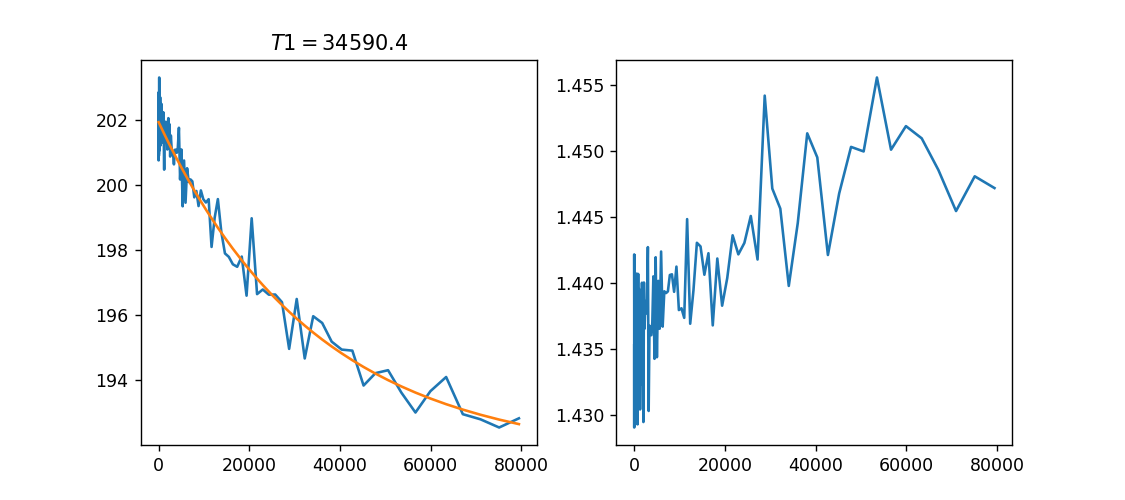

In [207]:
t_T1, q_target = np.logspace(0,4.9,201,endpoint=True), q3
await psg_ex1.setValue('Moutput','OFF')
job = Job(mr.T1, (q_target,measure,t_T1,True), tags=[tag], max=500,avg=True)
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1f$'%(1/T1))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

In [ ]:
q1 = q1._replace(T1=T1)

In [41]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.15, zpulse=None, f_lo=array([6.53062e+09]), delta=array([50000000.]), f_ex=array([3.714e+09]), delta_ex=array([0]), power_ex=30, power_rabi=4, pi_len=15.0, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': -0.024, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': -0.15, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0525, 'load': 'high Z', 'error': '+0'}, 'dc15': {'offset

# Ramsey

Output()

(18.881228425497103, 13.681883480603071, 30000, 2053.5, 0.0031840796019900496, 0)


<IPython.core.display.Javascript object>


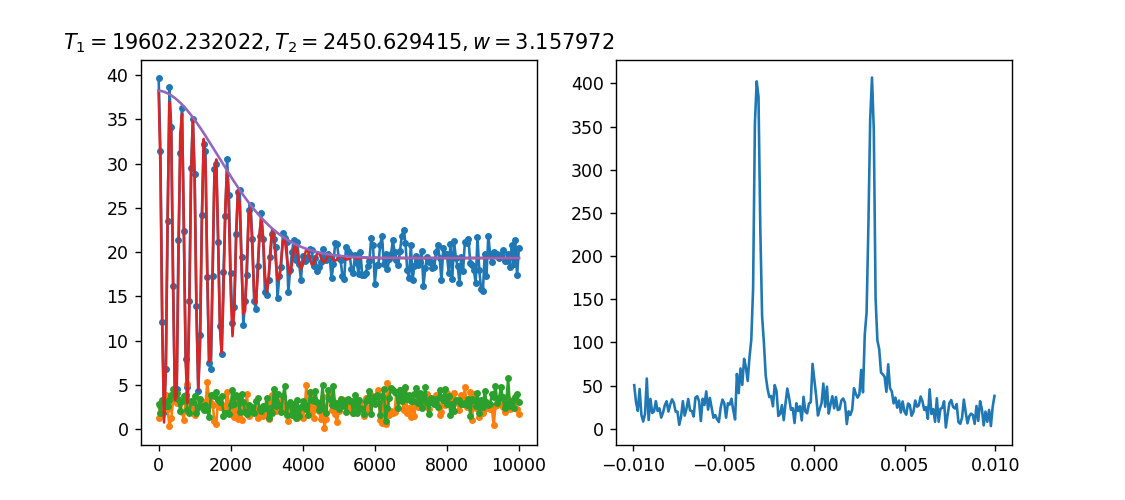

In [977]:
t_Ramsey, q_target, num = np.linspace(0,10000,201), q1, 0
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

job = Job(mr.Ramsey, (q_target,measure,t_Ramsey,True), tags=[tag], max=500,avg=True)
t_ram, s_ram = await job.done()
x, y = t_ram[:,num], (s_ram[:,num])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [978]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))

In [979]:
q1 = q1._replace(f_ex=(np.array([f-w*1e9])-110e6+3e6))

# SpinEcho

(44.74707525670158, 87.25163917933477, 29906.816112990695, 6658.9198701572805, 0.0029850746268656712, 0)


<IPython.core.display.Javascript object>


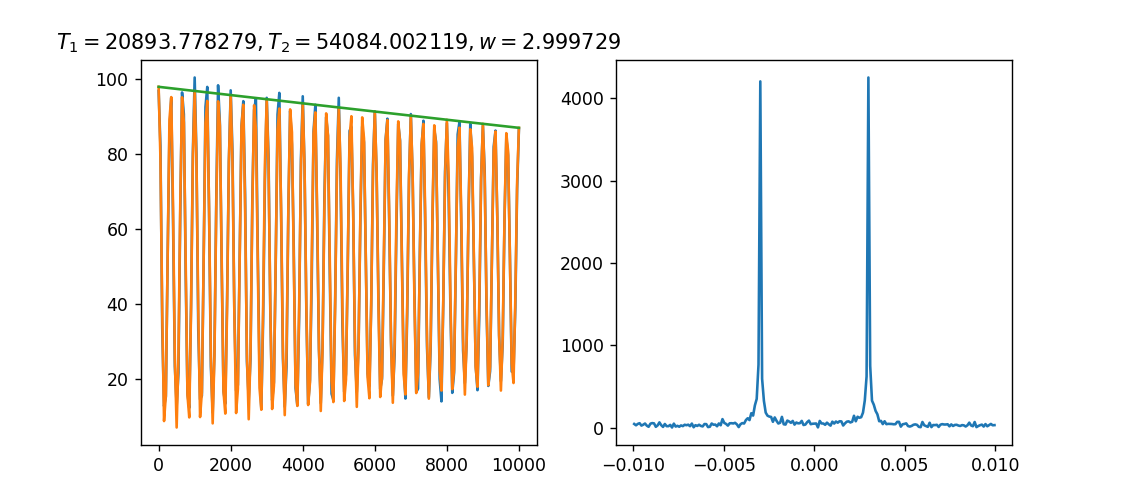

In [297]:
t_spin, q_target = np.linspace(0,10000,201), q3
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

job = Job(mr.SpinEcho, (q_target,measure,t_spin,1,'CPMG',True), tags=[tag], max=500,avg=True)
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], s_sp[:,0]
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

# CrossTalk矫正

In [ ]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [ ]:
z_crosstalk

# 普矫正

In [ ]:
v_rabi = np.linspace(-0.04,0.04,201)
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len(v_rabi),['Readout_Q']*len(v_rabi)]

In [ ]:
bits = [q2,q3,q4,q5]
count = 0
for v, k in enumerate(bits):
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_ex)
    await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits):
        comwave = True if count == 0 else False
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.crosstalkSpec, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),comwave), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await mr.InitInst(measure,psgdc=False,awgch=True)
            count += 1
    await mr.InitInst(measure,psgdc=True,awgch=True)

In [ ]:
measure.n = 1

# 二维谱

In [113]:
freq = np.arange(3.45,4.05,0.001)*1e9
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
bits_target = bits[:6]
for k, i in enumerate(bits_target):
    att_setup = mr.Att_Setup(measure,i.inst['com'])
    att_setup.Att(30)
    await mr.jpa_switch(measure,'ON')
    await awg133.output_on(ch=7)
    await awg133.output_on(ch=8)
    print(i.q_name)
    init = [1 if i.q_name==j.q_name else 0 for j in bits_target]
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    if k == 0:
        await dc[bits_target[k+1].inst['dc']].DC(-1)
    elif k == len(bits_target)-1:
        await dc[bits_target[k-1].inst['dc']].DC(-1)
    else:
        await dc[bits_target[k-1].inst['dc']].DC(-1)
        await dc[bits_target[k+1].inst['dc']].DC(-1)
    job = Job(mr.spec2d, (qubits,measure,freq,1,init,True), tags=[i.q_name], max=31)
    v_s2, f_s2, s_s2 = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

com11 open...
last ATT 00.0
now ATT 30.0
q1


Output()

com8 open...
last ATT 30.0
now ATT 30.0
q2


Output()

com8 open...
last ATT 30.0
now ATT 30.0
q3


Output()

com8 open...
last ATT 30.0
now ATT 30.0
q4


Output()

com13 open...
last ATT 20.0
now ATT 30.0
q5


Output()

com4 open...
last ATT 10.0
now ATT 30.0
q6


Output()

In [ ]:
np.linspace(-q3.T_bias[0]*0.3,q3.T_bias[0]*0.3,31) + q3.T_bias[1] 

In [111]:
q5

qubit(q_name='q5', inst={'dc': 'dc15', 'z_awg': 'awg131', 'z_ch': 5, 'ex_awg': 'awg133', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex1', 'com': 'com13'}, T_bias=[1.798, 0.064], specfunc=-24.2491131683623*cos(0.166901270293213*pi*x + 3.10635672710517) - 20.2024069833602, bias=-0.15, zpulse=None, f_lo=array([6.55858e+09]), delta=array([50000000.]), f_ex=array([3.92e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=13, pi_len=32.135, T1=None, state=[{'dc01': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc02': {'offset': 1.0, 'load': 'high Z', 'error': '+0'}, 'dc03': {'offset': 0.015, 'load': 'high Z', 'error': '+0'}, 'dc05': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc06': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc07': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc08': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc10': {'offset': 0.0, 'load': 'high Z', 'error': '+0'}, 'dc11': {'offset': 1.0, 'load': 'high Z', 'error': '+0'}, 'dc15': {'offset': -0.15,

# RB 

In [76]:
mlist, q_target, len_data = np.logspace(0.4,2.5,21,dtype=int), q3, 41
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len_data,['Readout_Q']*len_data]

In [77]:
gate = None
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB, (q_target,measure,mlist,len_data,gate,True), tags=[tag],no_bar=True)
n_RB, s_RB = await job.done()

Output()

In [78]:
pop = []
for j in range(np.shape(s_RB)[0]):
    s = np.array(s_RB[j])
    pm = []
    for i in range(np.shape(s)[1]):
        d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
        y = measure.predict(d)
        pm.append(list(y).count(0)/len(y))
    pop.append(pm)

<IPython.core.display.Javascript object>


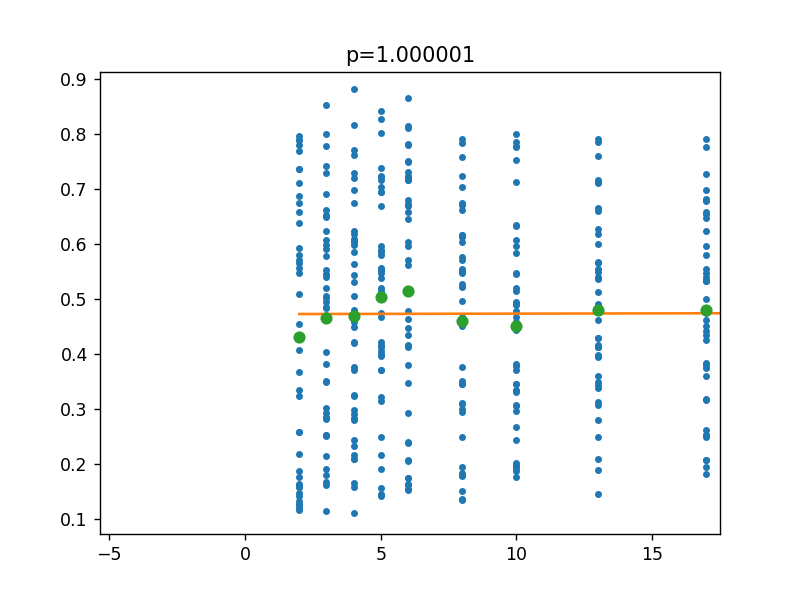

In [79]:
#n_RB = [1,5,10,20,50,100,150]
x = np.meshgrid(range(np.shape(pop)[1]),n_RB)[1]
plt.figure()
plt.plot(x.flatten(),np.array(pop).flatten(),'.')
plt.show()

In [32]:
def err(paras,x,y):
    A,B,p = paras
    return A*p**x+B-y
def guess(x,y):
    B = np.min(y)
    y = y - np.min(y)
    mask = y > 0
    a = np.polyfit(x[mask], np.log(y[mask]), 1)
    return np.exp(np.abs(a[1])), B, 1/np.exp(np.abs(a[0]))

In [33]:
x, y = n_RB, np.abs(np.mean(pop,axis=1))
p0 = guess(x,y)
res = ls(err, p0, args=(x, y)) 
A,B,p = res.x
fig = plt.gcf()
ax = plt.getp(fig,'axes')
z = A*p**x+B
ax[0].plot(x,z)
ax[0].plot(x,y,'o')
ax[0].set_title('p=%f'%p)
plt.show()

NameError: name 'n_RB' is not defined

In [ ]:
i = 20
s = np.array(s_RB[0])
d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s[:,i]),np.imag(s[:,i]),c=y,s=10)
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(n_RB,np.abs(s_RB[:,:,0].mean(axis=1)))
axes[1].plot(n_RB,np.angle(s_RB[:,:,0].mean(axis=1)))
plt.show()

# RB_waveform

## reference

In [759]:
mlist, q_target, len_data, which, gate = np.logspace(0.4,2.8,21,dtype=int), q1, 30, measure.offwhich, False
dragcoef = None
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,dragcoef,gate), tags=[q_target.q_name,'reference'],no_bar=True)
n_RBw, pop_RBw = await job.done()

Output()

<IPython.core.display.Javascript object>


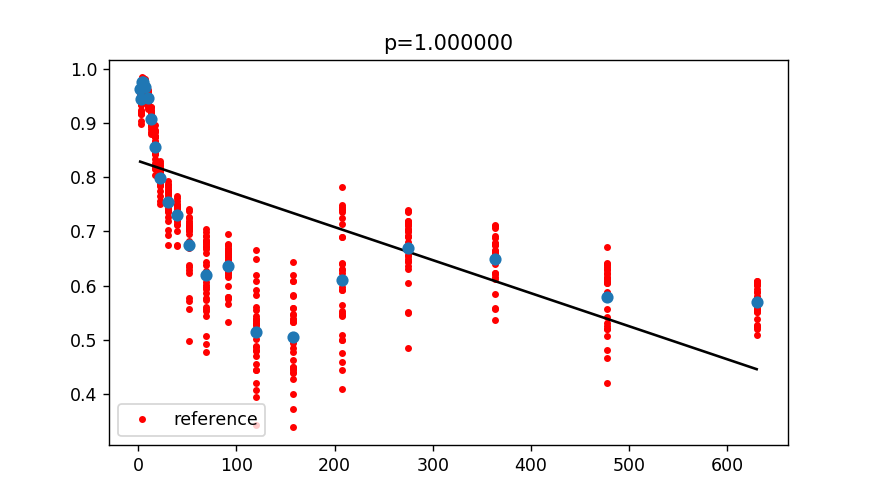

In [760]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label='reference')
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.title('p=%f'%p)
plt.show()

## gate

In [761]:
mlist, q_target, len_data, which = np.logspace(0.4,2.8,21,dtype=int), q1, 30, measure.offwhich
dragcoef = None

await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
for gate in ['2','3','4','5','6','7']:
    job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,dragcoef,gate), tags=[q_target.q_name,gate],no_bar=True)
    n_RBw, pop_RBw = await job.done()
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

Output()

Output()

Output()

Output()

Output()

Output()

<IPython.core.display.Javascript object>


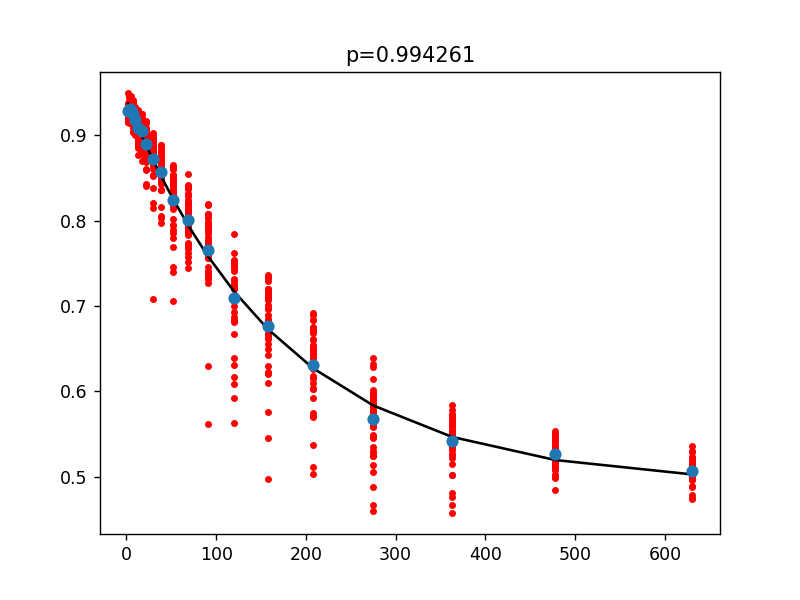

In [64]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label=gate)
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.set_title('p=%f'%p)
plt.show()

In [70]:
Pref, Pgate, d = 0.9946, 0.994261, 2**(1)
Rgate = (1-Pgate/Pref)*(1-1/d)
Rgate

-0.003516601051131496

# 单比特tomo

In [336]:
q_target, which = q3, measure.onwhich
dragcoef = None
t_rabi = np.linspace(1,33,33)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.tomo, (q_target,measure,t_rabi,which,dragcoef), tags=[q_target.q_name], max=len(t_rabi))
t_tomo, poplist = await job.done()

Output()

In [341]:
poplist

array([[0.43473101, 0.53105222, 0.04054589],
       [0.41515032, 0.58821203, 0.07179589],
       [0.42207278, 0.6627769 , 0.11135285],
       [0.43117089, 0.70114715, 0.13053797],
       [0.40704114, 0.7616693 , 0.20411392],
       [0.38568038, 0.80241297, 0.27511867],
       [0.42207278, 0.84375   , 0.39003165],
       [0.40941456, 0.86095728, 0.44244462],
       [0.40466772, 0.83168513, 0.49525316],
       [0.41356804, 0.80419304, 0.58781646],
       [0.41693038, 0.76483386, 0.640625  ],
       [0.40545886, 0.70549842, 0.69738924],
       [0.41890823, 0.69422468, 0.74564873],
       [0.40862342, 0.61293513, 0.80241297],
       [0.41139241, 0.54094146, 0.83188291],
       [0.41475475, 0.47409019, 0.83445411],
       [0.40704114, 0.4022943 , 0.84276108],
       [0.4153481 , 0.31388449, 0.8346519 ],
       [0.42998418, 0.26127373, 0.79410601],
       [0.41732595, 0.19125791, 0.75810918],
       [0.42681962, 0.13113133, 0.67523734],
       [0.43295095, 0.09276108, 0.61629747],
       [0.

In [342]:
data = [[1-2*j[i] for i in range(3)] for j in poplist]
data

[[0.13053797468354433, -0.06210443037974689, 0.9189082278481012],
 [0.16969936708860756, -0.17642405063291133, 0.8564082278481013],
 [0.1558544303797469, -0.32555379746835444, 0.7772943037974683],
 [0.13765822784810122, -0.40229430379746844, 0.7389240506329113],
 [0.18591772151898733, -0.5233386075949367, 0.5917721518987342],
 [0.2286392405063291, -0.6048259493670887, 0.4497626582278481],
 [0.1558544303797469, -0.6875, 0.21993670886075944],
 [0.18117088607594933, -0.7219145569620253, 0.11511075949367089],
 [0.19066455696202533, -0.6633702531645569, 0.009493670886076],
 [0.1728639240506329, -0.6083860759493671, -0.1756329113924051],
 [0.1661392405063291, -0.5296677215189873, -0.28125],
 [0.18908227848101267, -0.410996835443038, -0.3947784810126582],
 [0.16218354430379744, -0.38844936708860756, -0.49129746835443044],
 [0.182753164556962, -0.2258702531645569, -0.6048259493670887],
 [0.17721518987341767, -0.08188291139240511, -0.6637658227848102],
 [0.1704905063291139, 0.051819620253164556

In [343]:
np.savez('rabi_tomo_allxy_no.npz',data=data)